In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import l1_loss
import torch.distributions as dist

import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
## merge
# 1. calculate rho over the entire dataset seen so far
def calculate_rho(data, w, phi, sigma):
    h=torch.vstack([dist.MultivariateNormal(_phi, sigma).log_prob(data) for _phi in phi])
    log_weights = torch.log(w) + h.T # Compute log of weights * likelihood
    log_rho = log_weights - torch.logsumexp(log_weights, dim=1, keepdim=True)  # Normalize
    return torch.exp(log_rho).squeeze()

# 2. calculate cluster similarity
def calculate_cluster_similarity(rho, K):
    ## TODO: make similarity metric an arg?
    return (
        torch.tensor(
            [l1_loss(rho[:,i], rho[:,j], reduction='mean') if j > i else 0. 
            for i in range(K) for j in range(K)]
        )
        .view(K, K)
    )

# 3. identify those clusters to merge
def get_clusters_to_merge(cluster_similarity_matrix, similarity_threshold):
    mask = (cluster_similarity_matrix > 0) & (cluster_similarity_matrix < similarity_threshold)
    to_merge = torch.nonzero(mask, as_tuple=False)
    values_to_merge = cluster_similarity_matrix[mask]
    order = torch.argsort(values_to_merge, descending=False) # order clusters in order of most similar
    return to_merge[order]

# 4. calculate merge statistics
def get_merge_statistics(clusters_to_merge, phi, rho, K):
    merged = []
    all_to_prune = []
    merge_statistics = dict()

    for m in clusters_to_merge:
        if (m[0] not in merged) and (m[1] not in merged):
            all_to_prune.append(m[0].item()) # prune first idx
            # use second idx as update
            merge_statistics[m[1].item()] = {
                'phi': (phi[m[0]] + phi[m[1]]) / 2,
                'rho': rho[m[0]] + rho[m[1]]
            }
            merged.append(m[0])
            merged.append(m[1])
    
    # convert to boolean tensor
    all_to_prune = torch.tensor([i in all_to_prune for i in range(K)])
    return merge_statistics, all_to_prune

## apply merge, then apply prune
def apply_merge(merge_statistics, phi, w):
    phi = phi.detach() ## remove from computation graph temporarily
    for k, v in merge_statistics.items():
        phi[k] = v['phi']
        w[k] = v['rho']
    phi = phi.requires_grad_(True) # reattach to graph
    return phi, w

def prune(prune_idx: torch.Tensor, w: torch.Tensor, phi: torch.Tensor):
    w = w[~prune_idx]
    phi = phi[~prune_idx]
    K = w.size(0)
    return w, phi, K

def merge_and_prune(data, w, phi, rho, sigma, K, similarity_threshold):
    rho_prime = calculate_rho(data, w, phi, sigma)
    cluster_similarity_matrix = calculate_cluster_similarity(rho_prime, K)
    clusters_to_merge = get_clusters_to_merge(cluster_similarity_matrix, similarity_threshold)
    merge_statistics, all_to_prune = get_merge_statistics(clusters_to_merge, phi, rho, K)
    phi, w = apply_merge(merge_statistics, phi, w)
    w, phi, K = prune(all_to_prune, w, phi)
    return w, phi, K

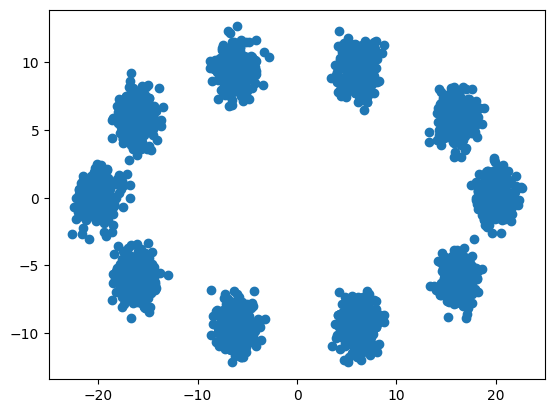

In [37]:

clusters = [
    dist.MultivariateNormal(
        torch.tensor([20*torch.cos(torch.tensor(i*math.pi/5)), 10*torch.sin(torch.tensor(i*math.pi/5))]),
        torch.diag(torch.ones(2,))
    ) for i in range(-5, 5)
]
N = 300
raw_data = torch.stack([
    d.sample(torch.tensor([N])) for d in clusters
]).reshape(-1, 2) 

data = raw_data.detach().numpy()
plt.scatter(
    data[:,0],
    data[:, 1]
)

In [38]:
n = raw_data.size(0)
lr = 1.0e-3
eps_new = .99

## pruning
eps_prune = .01
prune_freq = 100

## merging
eps_merge = .1
# merge_freq = 1000

K = 1
rho = torch.tensor([1.])
w = torch.tensor([1.])
alpha = torch.tensor([1.])
## set up base dist (mu of theta)
sigma = torch.diag(torch.ones(2,))
mu0 = torch.zeros((2,))
base_dist = dist.MultivariateNormal(mu0, 100*torch.diag(torch.ones(2,)))

## create first phi
phi = torch.nn.Parameter(raw_data[0,:]).unsqueeze(0)

## shuffle data
shuffdex = np.array(range(n))
np.random.shuffle(shuffdex)
data = raw_data[shuffdex,:]

for idx, i in enumerate(data[1:,:]):
    if (idx+1) % prune_freq == 0:
        to_prune = (w / w.sum()) < eps_prune
        w, phi, K = prune(to_prune, w, phi)
        print(f"Pruning, remaining clusters = {K} at obs {idx}...")

    # if (idx+1) % prune_freq == 0:
    #     to_prune = (w / w.sum()) < eps_prune
    #     prune_w = w[to_prune]
    #     prune_phi = phi[to_prune]
    #     print(
    #         f"Pruning at {idx + 1}...", 
    #         f"W:= {prune_w}",
    #         f"phi:= {prune_phi}",
    #         sep='\n'
    #     )
    #     w, phi, K = prune(to_prune, w, phi)
        # w, phi, K = merge_and_prune(data[:idx], w, phi, rho, sigma, K, eps_merge)
        # print(f"merged at {idx+1}: phi: {phi}, K: {K}")





    new_phi = torch.nn.Parameter(base_dist.sample())
    _phi = torch.vstack((phi, new_phi))
    _w = torch.concat((w, alpha))

    rho = calculate_rho(i, _w, _phi, sigma)



    if rho[K] > eps_new:
        # w is sum of rho across all previous obs
        w += rho[:K]
        w_next = torch.tensor([rho[K]])
        w = torch.concat((w, w_next))

        # add new params
        phi = torch.vstack((phi, new_phi))
        K += 1
        print(f"Increasing clusters to {K} at obs {idx}, located at: {new_phi}...")

    else:
        # renormalise to exclude K+1
        rho = rho[:K] / rho[:K].sum()

        # w is sum of rho across all previous obs
        w += rho[:K]

    d = np.min([1000, (idx+1)**.61])
    to_update = (base_dist.log_prob(phi) + d*rho.detach()*( dist.MultivariateNormal(phi, sigma).log_prob(i))).mean()
    # to_update = (rho.detach()*( dist.MultivariateNormal(phi, sigma).log_prob(i))).mean()
    

    grad_phi = torch.autograd.grad(to_update, phi,  retain_graph=True)[0]  # Compute gradient manually
    phi = phi + 1/d * grad_phi  # Apply gradient update
    phi = phi.detach().requires_grad_(True)  # Detach to prevent old computation graph accumulation


Increasing clusters to 2 at obs 1, located at: Parameter containing:
tensor([ -9.8533, -15.6299], requires_grad=True)...
Increasing clusters to 3 at obs 2, located at: Parameter containing:
tensor([ 9.2321, 17.9154], requires_grad=True)...
Increasing clusters to 4 at obs 6, located at: Parameter containing:
tensor([-17.1268,   6.5792], requires_grad=True)...
Increasing clusters to 5 at obs 40, located at: Parameter containing:
tensor([-3.7933,  8.6066], requires_grad=True)...
Increasing clusters to 6 at obs 44, located at: Parameter containing:
tensor([ 7.1556, -8.6582], requires_grad=True)...
Increasing clusters to 7 at obs 64, located at: Parameter containing:
tensor([-15.9044,   6.1056], requires_grad=True)...
Pruning, remaining clusters = 7 at obs 99...
Increasing clusters to 8 at obs 103, located at: Parameter containing:
tensor([15.9480, -0.0873], requires_grad=True)...
Pruning, remaining clusters = 8 at obs 199...
Pruning, remaining clusters = 8 at obs 299...
Pruning, remaining 

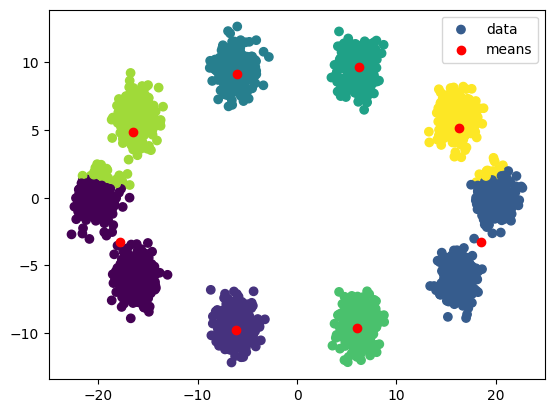

In [39]:
phi_np = phi.detach().numpy()

clusters = torch.argmax(
    torch.exp(dist.MultivariateNormal(phi, sigma).log_prob(data.unsqueeze(1)) ), 
    axis=1).detach().numpy()

k = data.detach().numpy()

probs = (w / w.sum()).detach().numpy()
plt.scatter(
    k[:,0], k[:,1],
    label='data',
    c = clusters
)
plt.scatter(
    phi_np[:,0],
    phi_np[:,1],
    label='means',
    c='red',
    # alpha = probs
)

plt.legend()

In [9]:
1/(300*10)**.6

0.008198364952831213

In [11]:
1/100000

1e-05

In [ ]:
def prune(prune_idx: torch.Tensor, w: torch.Tensor, phi: torch.Tensor):
    w = w[~prune_idx]
    phi = phi[~prune_idx]
    K = w.size(0)
    return w, phi, K

tensor([0.1634, 0.0581, 0.1425, 0.0745, 0.0103, 0.1679, 0.0855, 0.1489, 0.1488],
       grad_fn=<DivBackward0>)

In [17]:
(w == torch.tensor([.2, .6])).all()

tensor(True)

In [52]:
cluster_similarity_matrix = torch.tensor(
    [
        [0, .13, .12],
        [0, 0, .11],
        [0, 0, 0]
    ]
)
clusters_to_merge = get_clusters_to_merge(cluster_similarity_matrix, 0.2)
print(clusters_to_merge)

tensor([[1, 2],
        [0, 2],
        [0, 1]])


In [ ]:
def get_merge_statistics(clusters_to_merge, phi, rho, K):
    merged = []
    all_to_prune = []
    merge_statistics = dict()

    for m in clusters_to_merge:
        if (m[0] not in merged) and (m[1] not in merged):
            all_to_prune.append(m[0].item()) # prune first idx
            # use second idx as update
            merge_statistics[m[1].item()] = {
                'phi': (phi[m[0]] + phi[m[1]]) / 2,
                'rho': rho[m[0]] + rho[m[1]]
            }
            merged.append(m[0])
            merged.append(m[1])
    
    # convert to boolean tensor
    all_to_prune = torch.tensor([i in all_to_prune for i in range(K)])
    return merge_statistics, all_to_prune



phi = torch.tensor([[1,1], [2,2], [3,3]])
K = 3
rho = [1,2,3]
get_merge_statistics(clusters_to_merge, phi, rho, K)

({2: {'phi': tensor([2.5000, 2.5000]), 'rho': 5}},
 tensor([False,  True, False]))

In [ ]:
from algorithms.sva import *
data = torch.tensor([
    [1., 1.],
    [1, 1],
    [4., 4.],
    [4., 4.],
    [4., 4.]
])
phi = torch.tensor([[.9,.9], [1.1,1.1], [.9, 1.1], [4.,4.]])
sigma = torch.diag(torch.ones(2))
K = 4
w = torch.tensor([1.,1.,1.,1.])
# rho = torch.tensor([1,2,3])
rho_prime = calculate_rho(data, w, phi, sigma)
# rho_prime

cluster_distance_matrix = calculate_cluster_distance(rho_prime,K)
cluster_distance_matrix

tensor([[0.0000e+00, 9.3306e-05, 3.3063e-05, 7.3302e-01],
        [0.0000e+00, 0.0000e+00, 6.0244e-05, 7.3293e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.3299e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [29]:
t = torch.tensor([2.,1.,1.], requires_grad=True)

loss = torch.pow(t,2).sum()
loss.backward()

In [59]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.tensor(
    [[ 0.7307,  0.5456,  0.2734],
        [-0.4752, -0.4351,  1.7031],
        [-0.5691, -0.8719, -0.4268],
        [-0.3507,  1.3466, -0.2514],
        [-1.0563, -0.5244,  1.4734]],
        requires_grad = True
)
        #torch.randn(5, 3, requires_grad=True)
z = torch.matmul(x, w)
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [ ]:
from typing import Dict, Tuple
class DistDPMMParam:

    def __init__(
        self, 
        name: str,
        value: torch.distributions.Distribution | torch.Tensor,
        ):
        self.name = name
        self.value = value
    
    def get_value(self):
        if isinstance(self.value, torch.distributions.Distribution):
            return self.value.sample()
        else:
            return self.value
    
    def log_prob(self, x):
        if isinstance(self.value, torch.distributions.Distribution):
            return self.value.log_prob(x)
        else:
            ## NOTE: this works nicely for our purposes, but is this a sensible output?
            return 0

class BaseDist:

    def __init__(self, parameters):
        self.parameters = parameters
    
    def sample(self):
        return {
            param.name: param.get_value() for param in parameters
        }
    
    def log_prob(self, parameter_values):
        return torch.stack(
            [param.log_prob(parameter_values[param.name])
            for param in self.parameters]
        ).sum(axis=1)

class MixtureDPMM:

    def __init__(self, 
        mixture_dist: torch.distributions.Distribution, 
        parameters: Dict[str, torch.Tensor],
        learnable_parameters: Dict[str, bool]
        ):
        self.mixture_dist = mixture_dist # the type of distribution used
        self.parameters = parameters # dictionary of parameter values
        self.learnable_parameters = learnable_parameters # which parameters to keep gradients for
        self.K = 1

    def log_prob(self, x):
        return self.mixture_dist(**self.parameters).log_prob(x)

    def add_parameters(self, new_params):
        ## TODO: if parameter is learnable use nn.Parameter()
        for param_name, param_values in new_params.items():
            self.parameters[param_name] = torch.stack(
                (
                    nn.Parameter(param_values, requires_grad=self.learnable_parameters[param_name]), 
                    self.parameters[param_name])
            )
        self.K += 1
    
    def remove_parameters(self, remove_mask):
        for param_name in self.parameters.keys():
            self.parameters[param_name] = self.parameters[param_name][~remove_mask]
        self.K -= 1
    
    def remove_final_parameter(self):
        remove_mask = torch.tensor([(i+1)==self.K for i in range(self.K)])
        self.remove_parameters(remove_mask)

    def update_learnable_parameters(self, loss, lr):
        for param_name, is_learnable in self.learnable_parameters.items():
            if is_learnable:
                grad = torch.autograd.grad(loss, self.parameters[param_name], retrain_graph=True)[0]
                self.parameters[param_name] = self.parameters[param_name] + lr * grad
                self.parameters[param_name] = self.parameters[param_name].detach().requires_grad_(True)


mu0 = DistDPMMParam(name='loc', value = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)))
sigma0 = DistDPMMParam(
    name='covariance_matrix', 
    value = dist.Wishart(2, torch.eye(2))
    # value = torch.eye(2)
)
parameters = [
    mu0, sigma0
]

G = BaseDist(parameters)
s = G.sample()
# k = dist.MultivariateNormal(**s)
mixture = MixtureDPMM(
    dist.MultivariateNormal, 
    s, 
    learnable_parameters={'loc': True, "covariance_matrix": True}
)
new_s = G.sample()
mixture.add_parameters(new_s)
lp = mixture.log_prob(torch.tensor([1,1]))
print(mixture.parameters)
print(lp)
## how to remove the last parameter?
# get mask

# mixture.remove_final_parameter()
print(mixture.parameters)

# print(mixture.parameters)

{'loc': tensor([[ 0.7106,  0.7515],
        [-0.9957,  0.8966]], grad_fn=<StackBackward0>), 'covariance_matrix': tensor([[[ 4.0494, -1.4053],
         [-1.4053,  0.5046]],

        [[ 0.2618,  0.2780],
         [ 0.2780,  0.5733]]], grad_fn=<StackBackward0>)}
tensor([ -4.1127, -15.4427], grad_fn=<SubBackward0>)
{'loc': tensor([[ 0.7106,  0.7515],
        [-0.9957,  0.8966]], grad_fn=<StackBackward0>), 'covariance_matrix': tensor([[[ 4.0494, -1.4053],
         [-1.4053,  0.5046]],

        [[ 0.2618,  0.2780],
         [ 0.2780,  0.5733]]], grad_fn=<StackBackward0>)}


c:\Users\61417\Documents\misc_projects\sva_dpmm\venv\Lib\site-packages\torch\distributions\wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


In [197]:
G.parameters[0].log_prob(torch.tensor([1,1]))

tensor(-2.8379)

In [198]:
mixture.parameters

{'loc': tensor([[-0.3564, -1.5437],
         [ 0.9132, -0.5423]], grad_fn=<StackBackward0>),
 'covariance_matrix': tensor([[[ 7.0259, -2.3469],
          [-2.3469,  6.3664]],
 
         [[ 3.6696, -0.6898],
          [-0.6898,  0.9425]]], grad_fn=<StackBackward0>)}

In [215]:
base_log_probs = G.log_prob(mixture.parameters)
mixture_log_probs = mixture.log_prob(torch.tensor([1,1]))

In [216]:
mixture_log_probs

tensor([ -4.1127, -15.4427], grad_fn=<SubBackward0>)

In [ ]:
loss = 1/5*(base_log_probs + 5*mixture_log_probs)

tensor([ -5.1344, -16.4638], grad_fn=<MulBackward0>)

In [ ]:
for k in parameters.keys():
    grad = torch.autograd.grad(loss, parameters[k], retrain_graph=True)[0]
    self.parameters[k] = self.parameters[k] + lr * grad
    self.parameters[k] = self.parameters[k].detach().requires_grad_(True)

In [ ]:
        grad_phi = torch.autograd.grad(loss, self.phi,  retain_graph=True)[0]  # Compute gradient manually
        self.phi = self.phi + 1/d * grad_phi  # Apply gradient update
        self.phi = self.phi.detach().requires_grad_(True) # prevent old graph accumulation

In [203]:
base_log_probs['loc'] + base_log_probs['covariance_matrix'] + mixture_log_probs

tensor([-18.7625, -11.6650], grad_fn=<AddBackward0>)

In [201]:
mixture_log_probs

tensor([-4.6078, -3.8797], grad_fn=<SubBackward0>)

In [184]:
K=2
torch.tensor([(i+1)==K for i in range(mixture.K)])

tensor([False,  True])

In [174]:
mixture.get_log_probs(torch.tensor([1,1]))

[tensor(-2.6944), tensor(-5.1368)]

In [178]:
mixture.mixture_dist(**mixture.parameters).log_prob(torch.tensor([1,1]))

tensor([-2.6944, -5.1368])

In [173]:
list(zip(*[mixture.parameters[k] for k in mixture.parameters.keys()]))

[(tensor([ 0.3143, -0.4002]),
  tensor([[0.4970, 0.1642],
          [0.1642, 0.8929]])),
 (tensor([-0.0997, -1.2206]),
  tensor([[ 4.4007, -2.0601],
          [-2.0601,  2.7113]]))]

In [169]:
mixture.parameters

{'loc': tensor([0.6709, 0.2051]),
 'covariance_matrix': tensor([[0.2916, 0.8757],
         [0.8757, 2.6366]])}

In [119]:
## base dists
# mu0 = torch.zeros(2)
# sigma0 = torch.eye(2)
# G_mu = dist.MultivariateNormal(mu0, sigma0)
# G_sigma = dist.Wishart(df=2,precision_matrix=sigma0)
mu0 = DistDPMMParam(name='loc', value = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)))
sigma0 = DistDPMMParam(
    name='covariance_matrix', 
    value = dist.Wishart(2, torch.eye(2))
    # value = torch.eye(2)
)
parameters = [
    mu0, sigma0
]

G = BaseDist(parameters)
s = G.sample()
k = dist.MultivariateNormal(**s)

In [120]:
k.covariance_matrix

tensor([[10.2441,  5.3938],
        [ 5.3938,  2.9047]])

In [ ]:
k

In [ ]:
class DistDPMM:

    def __init__(self, 
        distribution: torch.distributions.Distribution, 
        params: list[DistDPMMParam]
        ):
        self.params = {param.name:param for param in params}
        self.distribution = distribution(**self.params)
    
    def sample(self):




tensor([[6.5951, 2.2006],
        [2.2006, 2.5922]])

In [101]:
w = dist.Wishart(df=2,covariance_matrix=sigma0)
w.sample()

tensor([[3.4923, 1.8635],
        [1.8635, 2.9276]])

In [ ]:
shape = torch.tensor([3.0, 4.0])  # Shape for each dimension
scale = torch.tensor([2.0, 5.0])  # Scale for each dimension
cluster_dist = dist.MultivariateNormal
base_dists = {
    'scale': dist.MultivariateNormal(torch.zeros(2), torch.eye(2)),
    'covariance_matrix': dist.InverseGamma(shape, scale)
    }
dpmm = DistDPMM(cluster_dist, base_dist)

In [91]:
dist.MultivariateNormal(torch.zeros(2), ig.sample())

ValueError: covariance_matrix must be at least two-dimensional, with optional leading batch dimensions

In [ ]:
tor

In [ ]:

ig = dist.InverseGamma(shape, scale)
torch.diag()


tensor([[0.3661, 0.0000],
        [0.0000, 1.3738]])

In [86]:
dpmm.base_dists['scale'].sample()
dpmm.base_dists['covariance_matrix'].sample()

tensor([1.4238])

In [54]:
loss.backward()
print(w.grad)


tensor([[0.0506, 0.1717, 0.3137],
        [0.0506, 0.1717, 0.3137],
        [0.0506, 0.1717, 0.3137],
        [0.0506, 0.1717, 0.3137],
        [0.0506, 0.1717, 0.3137]])


In [61]:
policy = torch.distributions.Normal(torch.zeros(1), torch.ones(1))
ploss = policy.log_prob(x)
print(ploss)

tensor([-1.4189, -1.4189, -1.4189, -1.4189, -1.4189])


In [62]:
(ploss.detach() * loss).mean().backward()
print(w.grad)

tensor([[-0.0718, -0.2437, -0.4451],
        [-0.0718, -0.2437, -0.4451],
        [-0.0718, -0.2437, -0.4451],
        [-0.0718, -0.2437, -0.4451],
        [-0.0718, -0.2437, -0.4451]])


In [131]:
rho_test = calculate_rho(data[:3], w, phi, sigma)
rho_test.size()

torch.Size([3, 18])

In [71]:
rho_prime[:,0] - rho_prime[:,1]

tensor([ 0.4560,  0.0000, -0.2522, -0.3642, -0.2522])

In [154]:
(
        torch.tensor(
            [l1_loss(rho_test[i,:], rho_test[j,:], reduction='mean') if j > i else 0. 
            for i in range(K) for j in range(K)]
        )
        .view(K, K)
    )

tensor([[0.0000, 0.6667, 0.0000],
        [0.0000, 0.0000, 0.6667],
        [0.0000, 0.0000, 0.0000]])

In [79]:
rho_test.size(), rho.size()

(torch.Size([9, 3]), torch.Size([100, 9]))

In [83]:
l1_loss(rho1, rho3, reduction='mean')

tensor(0.6667)

In [44]:
actual

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])